## Imports

In [63]:
# !sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet jupyterlab-vim)"
# !jupyter labextension enable

In [64]:
%load_ext autoreload
%autoreload 2

import arviz as az
import pymc as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Style notebook

In [65]:
plt.rcParams['figure.figsize'] = [8, 3]

# Chap1: Thinking probabilistically

# Chap 2: Programming probabilistically

## Probabilistic programming

In [66]:
np.random.seed(123)

trials = 4
# Unknown value.
theta_real = 0.35

# Generate some values.
data = stats.bernoulli.rvs(p=theta_real, size=trials)
print(data)

[1 0 0 0]


In [67]:
with pm.Model() as model:
    # - Prior.
    # \theta ~ Beta(\alpha=1, \beta=1) ~ Uniform[0, 1]
    theta = pm.Beta("theta", alpha=1.0, beta=1.0)
    # Likelihood.
    # - We pass the data using `observed` to condition the unknown to the knows (data).
    y = pm.Bernoulli('y', p=theta, observed=data)
    # Inference button.
    # - Compute 1000 samples from the posterior and store in `idata`.
    # - NUTS is a sampler that works for continuous variables.
    idata = pm.sample(1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


```
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
```
- NUTS sampler is an inference engine that works well for continuous variables

```
Multiprocess sampling (4 chains in 4 jobs)
```
- 4 chains are computed in parallel (based on the number of the available processors)

```
NUTS: [theta]
```
- Report which variable is sampled by which sampler

```
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
```
- 1,000 samples are used to tune the sampling algorithm and will be discarded

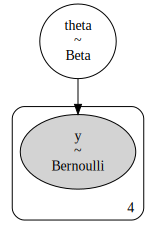

In [68]:
pm.model_to_graphviz(model)

In [69]:
print(type(idata))

<class 'arviz.data.inference_data.InferenceData'>


In [70]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [71]:
# import warnings
# warnings.filterwarnings("ignore")

In [72]:
# warnings.filterwarnings("error", category=FutureWarning, message="Series.__getitem__")

## Summarizing the posterior

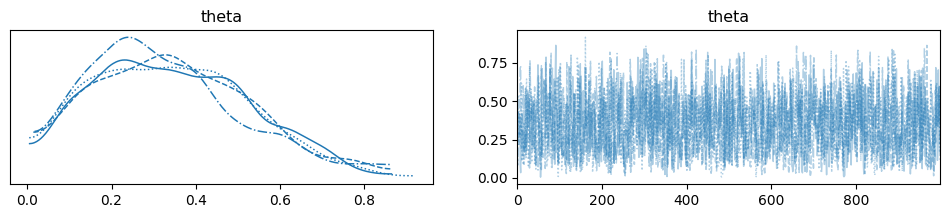

In [73]:
# Plot traces and Kernel Density Estimation (KDE) of the posterior (there are 4 posteriors) of the
# unobserved variable.
az.plot_trace(idata);

There is a KDE plot for each of the 4 chains
- They should look smooth and with a clear pattern
- They should look very similar

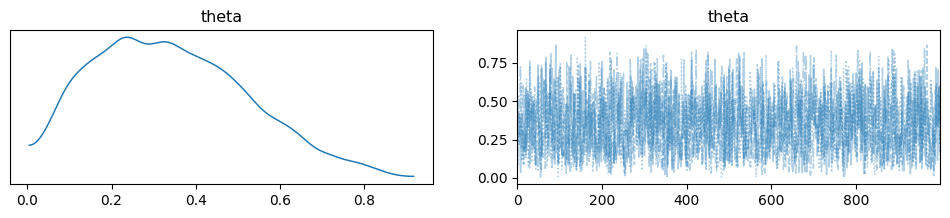

In [74]:
# Combine all the chains in a single distribution.
az.plot_trace(idata, combined=True);

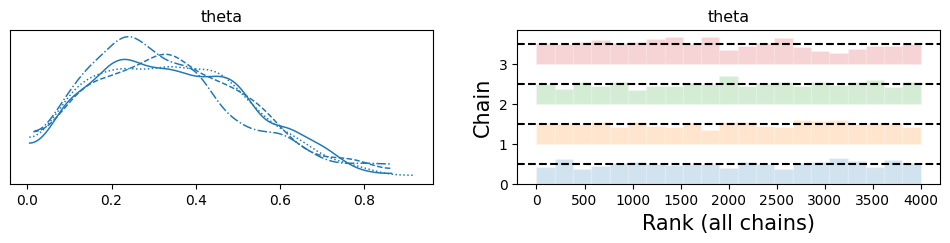

In [75]:
# Rank plot of the chains.
# We want the histograms of all the chains be uniform to ensure that we are exploring different regions of the posterior.
az.plot_trace(idata, kind="rank_bars");

In [76]:
az.summary(idata, kind="stats").round(2)

,mean,sd,hdi_3%,hdi_97%
theta,0.34,0.18,0.04,0.66


- The mean of the posterior value of `theta` is 0.34
- The value of `theta` is between 0.04 and 0.66 with 94% probabilitiy
- Note that the highest density interval is more precise than mean and std

In [77]:
# Summarize the posterior.
# mean, std dev, 94% HPD interval of the unknown param.
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.341,0.18,0.039,0.665,0.004,0.003,1729.0,2100.0,1.0


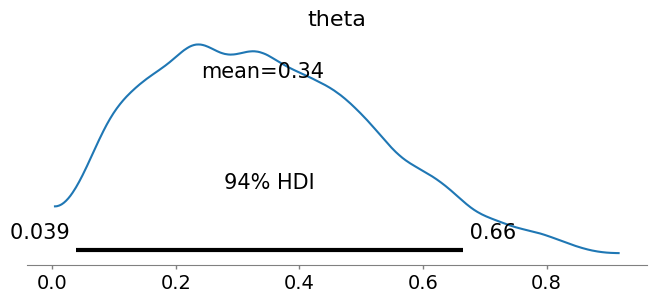

In [78]:
# Plot posterior.
az.plot_posterior(idata);

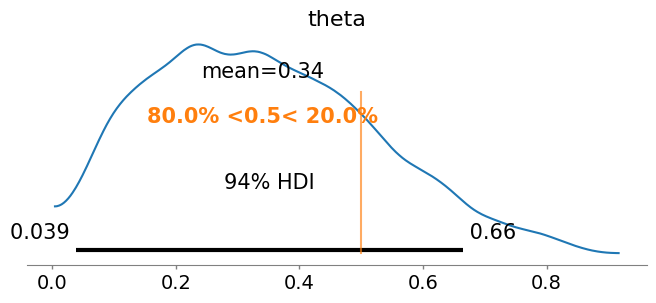

In [79]:
# Percentage of posterior below and above reference value.
az.plot_posterior(idata, ref_val=0.5);

### Savage-Dickey density ratio

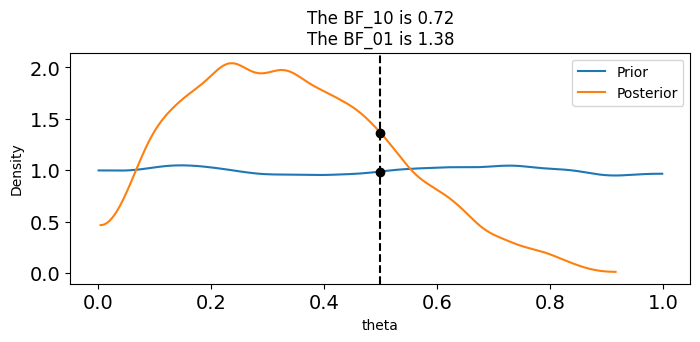

In [80]:
az.plot_bf(idata, var_name="theta", prior=np.random.uniform(0, 1, 10_000), ref_val=0.5);

### ROPE

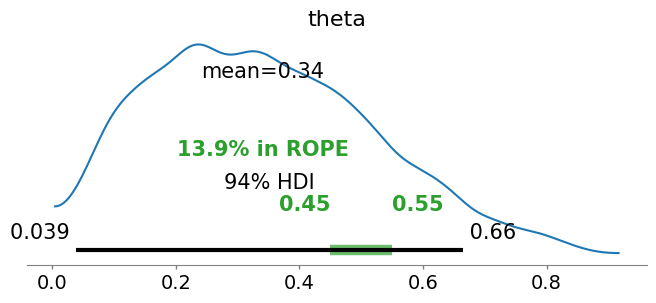

In [81]:
# KDE of posterior, ROPE, and % of posterior in ROPE.
az.plot_posterior(idata, rope=[0.45, 0.55]);

## Loss functions

In [82]:
#idata["theta"]
#idata.get_values('theta', chains=[0])
#idata.to_dataframe()

Text(0.5, 0, '$\\hat{\\theta}$')

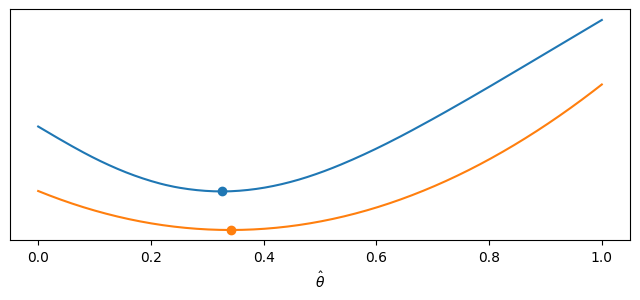

In [83]:
grid = np.linspace(0, 1, 200)
#print(grid)
#theta_pos = idata["theta"]
theta_pos = idata.to_dataframe()[("posterior", "theta")]

# Absolute loss.
lossf_a = [np.mean(abs(i - theta_pos)) for i in grid]
lossf_b = [np.mean((i - theta_pos) ** 2) for i in grid]

for lossf, c in zip([lossf_a, lossf_b], ["C0", "C1"]):
    # Plot loss.
    plt.plot(grid, lossf)
    #
    min_x = np.argmin(lossf)
    # Plot minimum value.
    plt.plot(grid[min_x], lossf[min_x], 'o', color=c)
    
#
plt.yticks([])
plt.xlabel(r'$\hat{\theta}$')

## Gaussian all the way down

### Gaussian inference

In [84]:
!ls /aux/code/book.2018.Martin.Bayesian_Analysis_with_Python.2e
dir_name = "/aux/code/book.2018.Martin.Bayesian_Analysis_with_Python.2e"

anscombe.csv	  book.Chap3.py			coal.csv     islands_dist.csv
babies.csv	  book.Chap4.ipynb		dummy.c      redwood.csv
book.Chap1.ipynb  book.Chap5.ipynb		dummy.csv    space_flu.csv
book.Chap1.py	  book.Chap6.ipynb		fish.csv     tips.csv
book.Chap2.ipynb  book.Chap7.ipynb		howell.csv
book.Chap2.py	  chemical_shifts.csv		iris.csv
book.Chap3.ipynb  chemical_shifts_theo_exp.csv	islands.csv


48
[51.06 55.12 53.73 50.24 52.05 56.4  48.45 52.34 55.65 51.49 51.86 63.43
 53.   56.09 51.93 52.31 52.33 57.48 57.44 55.14 53.93 54.62 56.09 68.58
 51.36 55.47 50.73 51.94 54.95 50.39 52.91 51.5  52.68 47.72 49.73 51.82
 54.99 52.84 53.19 54.52 51.46 53.73 51.61 49.81 52.42 54.3  53.84 53.16]


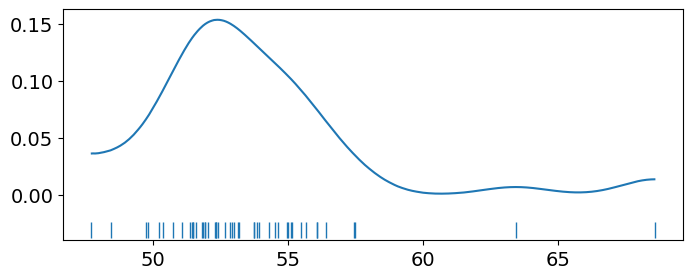

In [85]:
data = np.loadtxt(f"{dir_name}/chemical_shifts.csv")
print(len(data))
print(data)
#print(sorted(data))

# It looks Gaussian with a couple of outliers.
az.plot_kde(data, rug=True);

In [86]:
with pm.Model() as model_g:
    # The mean is Uniform in [40, 70] (which is larger than the data).
    mu = pm.Uniform("mu", lower=40, upper=70)
    # The std dev is half normal with a large value (which is a large value based on the data).
    sigma = pm.HalfNormal("sigma", sigma=10)
    # The model is N(mu, sigma).
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=data)
    # Sample.
    idata_g = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


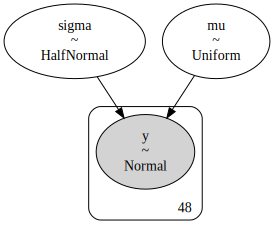

In [87]:
pm.model_to_graphviz(model_g)

In [88]:
#az.style.use("arviz-darkgrid")

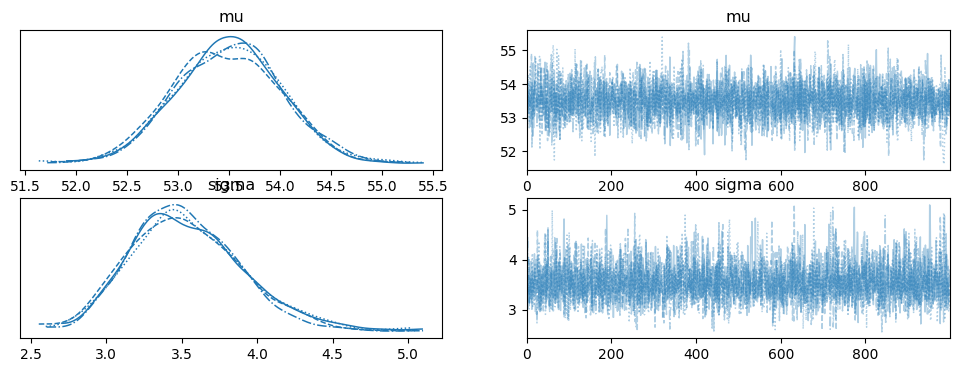

In [89]:
# There are 2 traces.
az.plot_trace(idata_g);

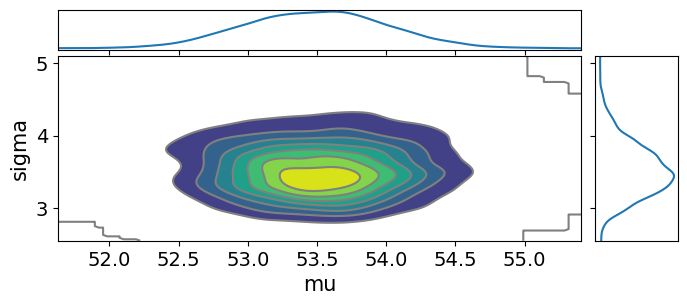

In [90]:
# The posterior distribution of the params is bi-dimensional, since it has mu and sigma.
az.plot_pair(idata_g, kind='kde', marginals=True);

In [91]:
idata_g

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [92]:
# Extract the 2 chains of the posterior.
#idata_g.posterior["chain"]

In [93]:
# Extract the posterior.
#posterior = az.extract(idata_g)
#posterior

In [94]:
# Report a summary of the inference.
az.summary(idata_g, kind="stats").round(2)

,mean,sd,hdi_3%,hdi_97%
mu,53.49,0.52,52.54,54.48
sigma,3.54,0.38,2.89,4.28


### Posterior predictive check
$$\Pr(\hat{y} | y) = \int \Pr(\hat{y} | \theta) \Pr(\theta | y) d\theta$$

In [95]:
# Compute 100 posterior predictive samples.
y_pred_g = pm.sample_posterior_predictive(idata_g, model=model_g)

Sampling: [y]


Output()

In [96]:
y_pred_g

Inference data with groups:
	> posterior_predictive
	> observed_data

In [97]:
#?az.plot_ppc

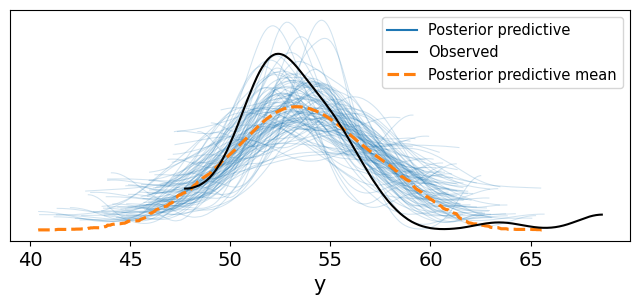

In [98]:
# Black line is KDE of the data (observed)
# Blue lines are KDEs of the posterior predictive samples
az.plot_ppc(y_pred_g, mean=True, num_pp_samples=100);

- The mean of the posterior looks more on the right than the data
- The std dev of the posterior looks larger
- This is a result of the two "outliers" from the bulk of the distribution

## Robust inference

One could argue that the assumption of gaussianity of the data is incorrect
- The normal distribution is "surprised" to see outliers
- The result is fitting too much

Solutions
1) Remove the outliers
2) Change the model
    - E.g., switch from Gaussian to T-distribution

In [99]:
# Almost Gaussian (df \to \infty)
vals = stats.t(loc=0, scale=1, df=100).rvs(1000)
print(vals[:10])
print(np.mean(vals))
print(np.std(vals))

[ 0.14128582 -0.73492028  0.05123072  1.37215586 -1.10273849  0.02512005
  0.89172859 -0.99089054 -0.47019869  0.06933757]
-0.01011387095619419
1.0194226762709382


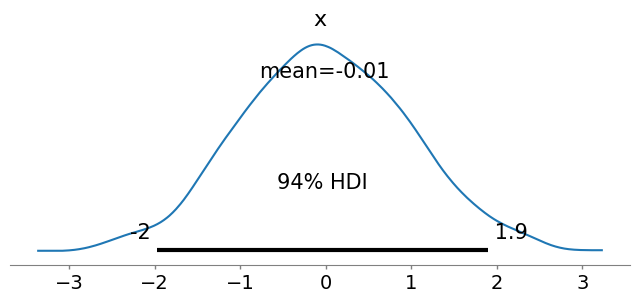

In [100]:
az.plot_posterior(vals);

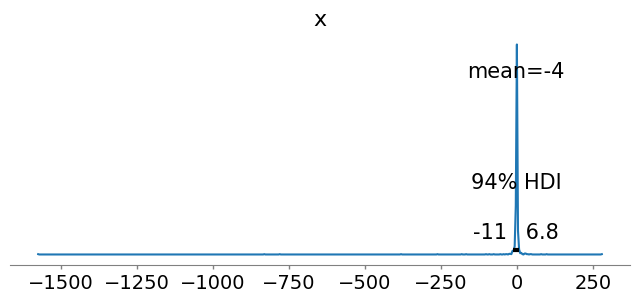

In [101]:
# Cauchy (df=1)
az.plot_posterior(stats.t(loc=0, scale=1, df=1).rvs(1000));

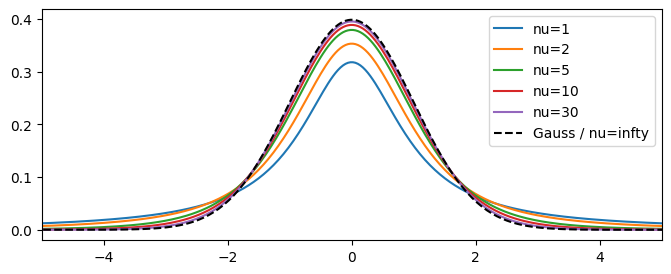

In [102]:
# Show the PDF for various values of \nu.

# Points to be used to sample the PDF.
x_values = np.linspace(-10, 10, 500)

# Plot t-student sweeping \nu.
for df in [1, 2, 5, 10, 30]:
    # Student-t with df.
    distr = stats.t(df)
    # Compute PDF.
    x_pdf = distr.pdf(x_values)
    plt.plot(x_values, x_pdf, label=f"nu={df}")
    
# Plot gaussian.
x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, "k--", label="Gauss / nu=infty")

plt.xlim(-5, 5) 
plt.legend();

In [103]:
# Use a Student-T model.
with pm.Model() as model_t:
    mu = pm.Uniform("mu", 40, 75)
    sigma = pm.HalfNormal("sigma", sigma=10)
    # A student with nu = 30 is close to a Gaussian.
    nu = pm.Exponential("nu", 1/30)
    #
    y = pm.StudentT("y", mu=mu, sigma=sigma, nu=nu, observed=data)
    idata_t = pm.sample(1_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


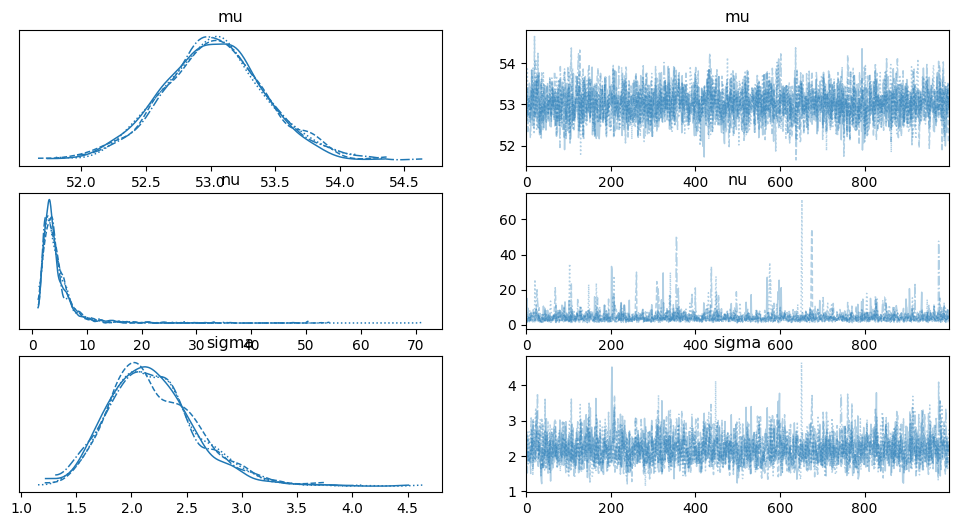

In [104]:
az.plot_trace(idata_t);

- mu is similar to the estimate with a Gaussian
- sigma is smaller
- nu ~ 5, which is not very Gaussian

The outliers have the effect of decreasing nu, instead of pulling the mean towards them
and increasing the std.

In [105]:
az.summary(idata_t, kind="stats").round(2)

,mean,sd,hdi_3%,hdi_97%
mu,53.02,0.39,52.28,53.77
nu,4.62,3.83,1.33,9.31
sigma,2.19,0.40,1.49,2.95


In [106]:
# Compute 100 posterior predictive samples.
y_ppc_t = pm.sample_posterior_predictive(idata_t, model_t)

Sampling: [y]


Output()

(40.0, 70.0)

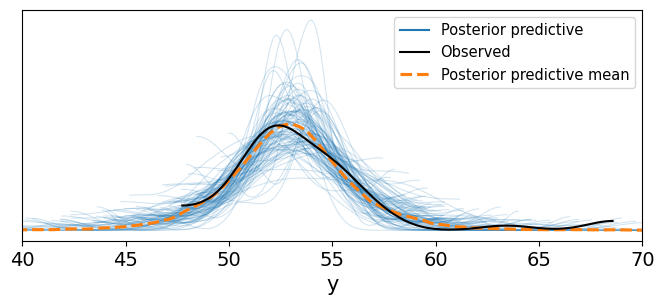

In [107]:
ax = az.plot_ppc(y_ppc_t, num_pp_samples=100, mean=True)
ax.set_xlim(40, 70)

- The plot is "hairy".
- The reason is that KDE is estimated only in the actual interval of the data, and it's 0 outside.


## Inference data

In [108]:
idata_g = idata_g

idata_g

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [109]:
posterior = idata_g["posterior"]
posterior

<xarray.Dataset> Size: 72kB
Dimensions:  (chain: 4, draw: 1000)
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    mu       (chain, draw) float64 32kB 53.4 53.58 53.18 ... 54.16 54.16 53.04
    sigma    (chain, draw) float64 32kB 3.124 3.247 3.177 ... 3.279 3.279 3.694
Attributes:
    created_at:                 2024-09-05T11:37:13.505129+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2
    sampling_time:              0.8790431022644043
    tuning_steps:               1000

In [110]:
# Select the first draw from chain 0 and 2.
posterior.sel(draw=0, chain=[0, 2])

<xarray.Dataset> Size: 56B
Dimensions:  (chain: 2)
Coordinates:
  * chain    (chain) int64 16B 0 2
    draw     int64 8B 0
Data variables:
    mu       (chain) float64 16B 53.4 53.95
    sigma    (chain) float64 16B 3.124 3.597
Attributes:
    created_at:                 2024-09-05T11:37:13.505129+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2
    sampling_time:              0.8790431022644043
    tuning_steps:               1000

In [111]:
# First 100 draws from all chains.
posterior.sel(draw=slice(0, 100))

<xarray.Dataset> Size: 7kB
Dimensions:  (chain: 4, draw: 101)
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 808B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99 100
Data variables:
    mu       (chain, draw) float64 3kB 53.4 53.58 53.18 ... 52.96 53.77 53.27
    sigma    (chain, draw) float64 3kB 3.124 3.247 3.177 ... 3.796 3.369 3.532
Attributes:
    created_at:                 2024-09-05T11:37:13.505129+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2
    sampling_time:              0.8790431022644043
    tuning_steps:               1000

In [112]:
posterior.mean()

<xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    mu       float64 8B 53.49
    sigma    float64 8B 3.539

In [113]:
# Combine all the `chain` in a single one.
stacked = az.extract(idata_g)
stacked

<xarray.Dataset> Size: 160kB
Dimensions:  (sample: 4000)
Coordinates:
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    mu       (sample) float64 32kB 53.4 53.58 53.18 54.04 ... 54.16 54.16 53.04
    sigma    (sample) float64 32kB 3.124 3.247 3.177 3.473 ... 3.279 3.279 3.694
Attributes:
    created_at:                 2024-09-05T11:37:13.505129+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2
    sampling_time:              0.8790431022644043
    tuning_steps:               1000

## Group comparison

In [114]:
import pandas as pd
import seaborn as sns
import pprint

In [115]:
tips = pd.read_csv(dir_name + '/tips.csv')
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


- Study the effect of the day of the week on the tips earned at a restaurant

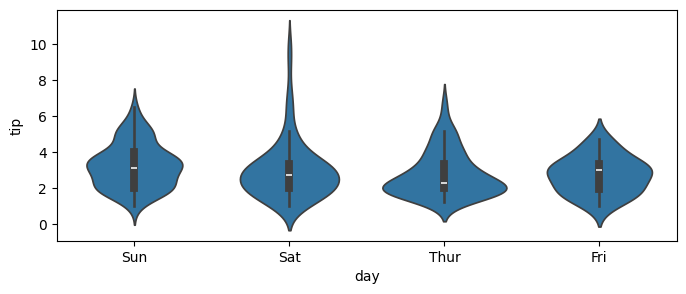

In [116]:
sns.violinplot(x='day', y='tip', data=tips);

In [117]:
# Extract the tips.
tip = tips['tip'].values
print(tip[:10])

# Create a vector going from day to group idx.
idx = pd.Categorical(tips['day']).codes
print("idx=", idx)

# Count the groups.
groups = np.unique(idx)
n_groups = len(groups)
print("groups=", n_groups, groups)

[1.01 1.66 3.5  3.31 3.61 4.71 2.   3.12 1.96 3.23]
idx= [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3]
groups= 4 [0 1 2 3]


In [118]:
# The model is the same as before but it can be easily vectorized.
# There is no need to write a for-loop.
with pm.Model() as comparing_groups:
    # mu is a vector of 4 elems.
    mu = pm.Normal('mu', mu=0, sigma=10, shape=n_groups)
    # sigma is a vector of 4 elems.
    sigma = pm.HalfNormal("sigma", sigma=10, shape=n_groups)
    # y is a vector of 4 normals each with mean and sigma for the group.
    y = pm.Normal('y', mu=mu[idx], sigma=sigma[idx], observed=tip)
    idata_cg = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.


### Model from xarray.Dataset

In [119]:
categories = np.array("Thur Fri Sat Sun".split())
coords = {"days": categories, "days_flat": categories[idx]}
print("coords=", pprint.pformat(coords))

coords= {'days': array(['Thur', 'Fri', 'Sat', 'Sun'], dtype='<U4'),
 'days_flat': array(['Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat',
       'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat',
       'Sat', 'Fri', 'Fri', 'Fri', 'Fri', 'Fri', 'Fri', 'Fri', 'Fri',
       'Fri', 'Fri', 'Fri', 'Fri', 'Fri', 'Fri', 'Fri', 'Fri', 'Fri',
       'Fri', 'Fri', 'Fri', 'Fri', 'Fri', 'Sat', 'Sat', 'Sat', 'Sat',
       'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat',
       'Sat', 'Sat', 'Fri', 'Fri', 'Fri', 'Fri', 'Fri', 'Fri', 'Fri',
       'Fri', 'Fri', 'Fri', 'Fri', 'Fri', 'Fri', 'Fri', 'Fri', 'Fri',
       'Fri', 'Fri', 'Fri', 'Fri', 'Fri', 'Sun', 'Sun', 'Sun', 'Sun',
       'Sun', 'Sun', 'Sun', 'Sun', 'Sun', 'Sun', 'Sun', 'Sun', 'Sun',
       'Thur', 'Thur', 'Thur', 'Thur', 'Thur', 'Thur', 'Thur', 'Thur',
       'Thur', 'Thur', 'Thur', 'Thur', 'Fri', 'Fri', 'Fri', 'Fri', 'Fri',
       'Fri', 'Fri', 'Fri', 'Fri', 'Fri', 'Sat', 'Sat', 'Sat', 'Sat',
   

In [120]:
with pm.Model(coords=coords) as comparing_groups:
    mu = pm.HalfNormal("mu", sigma=5, dims="days")
    sigma = pm.HalfNormal("sigma", sigma=1, dims="days")
    y = pm.Gamma("y", mu=mu[idx], sigma=sigma[idx], observed=tip, dims="days_flat")
    idata_cg = pm.sample()
    idata_cg.extend(pm.sample_posterior_predictive(idata_cg))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [y]


Output()

In [121]:
idata_cg

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

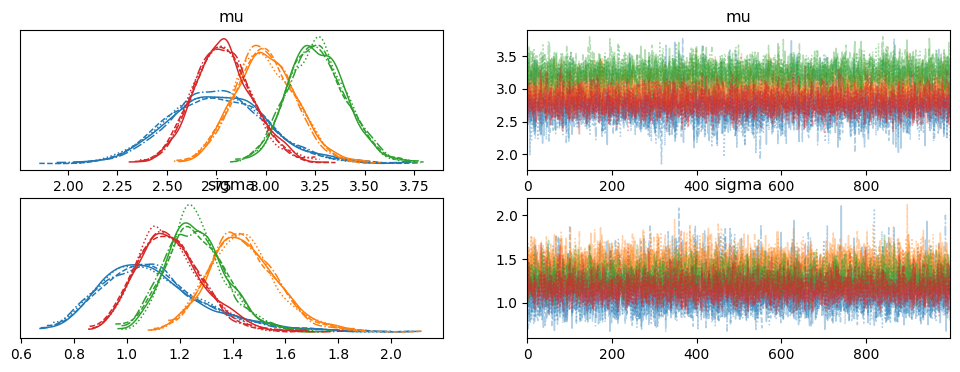

In [122]:
az.plot_trace(idata_cg);

array([<Axes: xlabel='y\nSat'>, <Axes: xlabel='y\nFri'>,
       <Axes: xlabel='y\nSun'>, <Axes: xlabel='y\nThur'>], dtype=object)

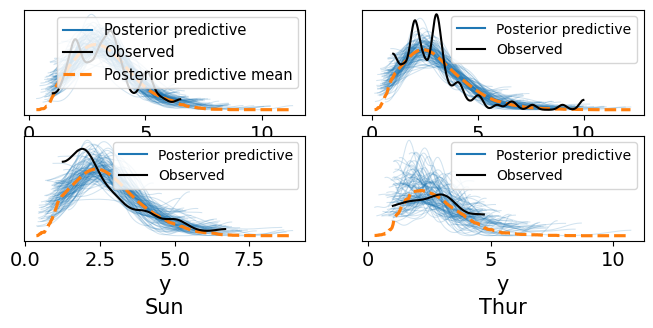

In [123]:
_, axes = plt.subplots(2, 2)
az.plot_ppc(idata_cg, num_pp_samples=100,
            coords={"days_flat": [categories]},
            flatten=[],
            ax=axes)

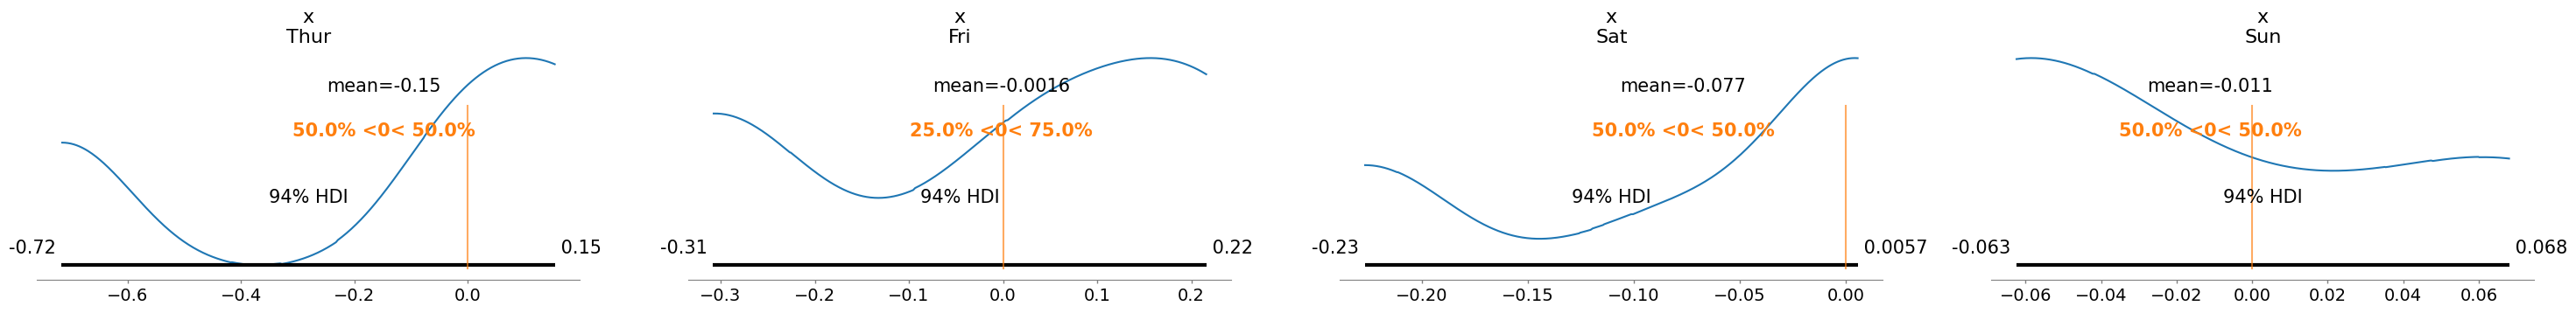

In [124]:
i = 0
j = 1
mean_diff = idata_cg.posterior['mu'][:, i] - idata_cg.posterior['mu'][:, j]
sd1 = idata_cg.posterior['sigma'][:, i] ** 2
sd2 = idata_cg.posterior['sigma'][:, j] ** 2

cohen_d = mean_diff / np.sqrt((sd1 + sd2)/2)
#print(cohen_d)

#plt.plot(cohen_d)
az.plot_posterior(cohen_d, ref_val=0);